In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from yacs.config import CfgNode

from src.features.perception import get_ray_directions_world_coords, propagate_labels
from src.features.raytracing import raytrace_3d
from src.visualisation.map_visualisation import draw_voxels


In [2]:
def raytracing3d_map_visualisation_sensor_cfg() -> CfgNode:
    sensor_cfg = CfgNode()
    sensor_cfg.WIDTH = 256 #px
    sensor_cfg.HEIGHT = 128 #px
    sensor_cfg.HFOV = 90 #deg
    sensor_cfg.SENSOR_HEIGHT = 0.88 #m
    return sensor_cfg

def raytracing3d_map_visualisation_cfg():
    cfg = CfgNode()
    cfg.RESOLUTION = 1.0  # cm per pixel
    cfg.EGOCENTRIC_MAP_SHAPE = (20,20,20)  # (x, y, z) in pixel
    cfg.NUM_SEMANTIC_CLASSES = 5
    cfg.SENSOR_CFG = raytracing3d_map_visualisation_sensor_cfg()
    return cfg

def raytracing3d_ray_visualisation_sensor_cfg() -> CfgNode:
    sensor_cfg = CfgNode()
    sensor_cfg.WIDTH = 32 #px
    sensor_cfg.HEIGHT = 16 #px
    sensor_cfg.HFOV = 90 #deg
    sensor_cfg.SENSOR_HEIGHT = 0.88 #m
    return sensor_cfg

def raytracing3d_ray_visualisation_cfg():
    cfg = CfgNode()
    cfg.RESOLUTION = 1.0  # cm per pixel
    cfg.EGOCENTRIC_MAP_SHAPE = (20,20,20)  # (x, y, z) in pixel
    cfg.NUM_SEMANTIC_CLASSES = 5
    cfg.SENSOR_CFG = raytracing3d_ray_visualisation_sensor_cfg()
    return cfg

def generate_semantic_map(cfg, seed = None, p = 0.05):
    rng = np.random.default_rng(seed)
    grid_classes = rng.choice(np.arange(cfg.NUM_SEMANTIC_CLASSES), size = cfg.EGOCENTRIC_MAP_SHAPE)

    grid_classes_onehot = np.zeros((grid_classes.size, grid_classes.max() + 1))
    grid_classes_onehot[np.arange(grid_classes.size), grid_classes.flatten()] = 1
    grid_classes_onehot = grid_classes_onehot.reshape(cfg.EGOCENTRIC_MAP_SHAPE + (cfg.NUM_SEMANTIC_CLASSES,))
    
    grid=rng.choice([0,1], size = cfg.EGOCENTRIC_MAP_SHAPE, p = [1-p, p])
    grid_classes_onehot[grid == 0 ,:] = 0
    
    semantic_map_3d = np.concatenate([np.expand_dims(grid, -1), grid_classes_onehot], axis = -1).astype(float)
    return semantic_map_3d

In [4]:
sim_cfg = raytracing3d_map_visualisation_cfg()
semantic_map_3d = generate_semantic_map(sim_cfg)
sensor_position = (-1, 2, 3)
rotation_float = np.random.rand(3)
rotation_float[1] = 0
rotation_float = rotation_float / np.linalg.norm(rotation_float)
sensor_rotation = np.quaternion(rotation_float[0], rotation_float[1], rotation_float[2], 0)
grid_index_of_origin = (5,6,7)

In [5]:
semantic_map_2d = propagate_labels(sensor_rotation, sensor_position, semantic_map_3d, grid_index_of_origin, sim_cfg)

In [214]:
colors = px.colors.sample_colorscale("viridis",
                                     [n/(sim_cfg.NUM_SEMANTIC_CLASSES -1) for n in range(sim_cfg.NUM_SEMANTIC_CLASSES)])


colors.append("rgb(0,0,0)")

pixel_classes = np.argmax(semantic_map_2d, axis = -1)
pixel_classes[np.all(semantic_map_2d == 0, 2)] = sim_cfg.NUM_SEMANTIC_CLASSES
pixel_colors = np.zeros((pixel_classes.shape[0], pixel_classes.shape[1], 3))
colors_numpy = np.array([np.array([int(y) for y in (''.join([x for x in color if x.isdigit() or x == ','])).split(',')]) for color in colors])
pixel_colors[:,:,:] = colors_numpy[pixel_classes[:,:]]
pixel_colors = pixel_colors.astype(int)

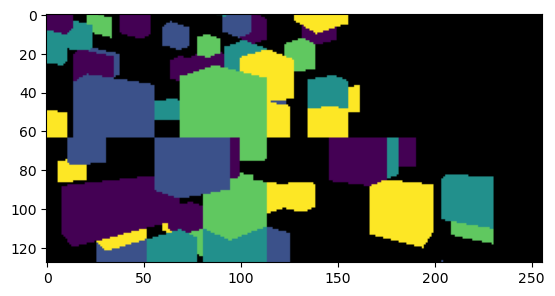

In [215]:
plt.imshow(pixel_colors.transpose(1,0,2))

### Show rays and 3d map

In [216]:
ray_sim_cfg = raytracing3d_ray_visualisation_cfg()

ray_directions = get_ray_directions_world_coords(sensor_rotation, ray_sim_cfg.SENSOR_CFG)

ray_directions_flat = ray_directions.reshape(3, -1)

ray_labels, intersections = raytrace_3d(ray_directions_flat, semantic_map_3d, sensor_position, grid_index_of_origin,
                                         ray_sim_cfg, True)

In [217]:
voxels, colors = draw_voxels(semantic_map_3d, grid_index_of_origin, ray_sim_cfg, return_colors=True)

fig = go.Figure()
for f in voxels:
    fig.add_traces(f.data)

colors.append('rgb(75,0,0)')

black_line_shown = False
for (ray_index, ray), ray_label in zip(intersections.items(), ray_labels):
    
    if ray_label[0] == 0:
        ray_class = -1
    else:
        ray_class = int(np.argwhere(ray_label[1:] == 1)[0])
    
    showlegend = False
    if not black_line_shown and ray_class == -1:
        showlegend = True
        black_line_shown = True
    name = 'Unclassified rays' if ray_class == -1 else str(ray_class)
    line = go.Figure(data = go.Scatter3d(x = [i[0] for i in ray], 
                                         y = [i[1] for i in ray], 
                                         z = [i[2] for i in ray], mode = 'lines',
                                         line = dict(color = colors[ray_class], width = 5),
                                         showlegend=showlegend,
                                         legendgroup = colors[ray_class],
                                         name=name))
    fig.add_traces(line.data)

camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.update_layout(
    autosize=False,
    width=500,
    height=500, 
    margin=dict(l=0, b=0),
    template = "plotly_dark",
    showlegend=True,
    legend_title_text='Semantic category',
    title="Try Clicking on the Legend Items!",
    scene_camera = camera
    )

fig.update_layout()
fig.show()